导入相关库

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

数据预处理

In [2]:
# 读取数据
df = pd.read_csv("data/processed_binary_compounds.csv")

# 要处理的列
stress_cols = ["sxy", "syz", "szx"]

# 替换值为0的项为该列的非零中位数
for col in stress_cols:
    non_zero_median = df.loc[df[col] != 0, col].median()
    df[col] = df[col].replace(0, non_zero_median)

print(df.shape)
df.columns.values

(10000, 22)


array(['delta_e', 'stability', 'natoms', 'ntypes',
       'element_1_atomic_radii', 'element_1_electronegativity',
       'element_1_mass', 'element_1_covalent_radii',
       'element_1_first_ionization_energy', 'element_2_atomic_radii',
       'element_2_electronegativity', 'element_2_mass',
       'element_2_covalent_radii', 'element_2_first_ionization_energy',
       'spacegroup_id', 'volume_pa', 'sxx', 'syy', 'szz', 'sxy', 'syz',
       'szx'], dtype=object)

特征工程

In [3]:
# 1. 电负性差值
df['electronegativity_diff'] = df['element_1_electronegativity'] - df['element_2_electronegativity']

# 2. 原子半径比值（防止除零）
df['atomic_radii_ratio'] = df['element_1_atomic_radii'] / (df['element_2_atomic_radii'] + 1e-6)

# 3. 原子质量差
df['mass_diff'] = df['element_1_mass'] - df['element_2_mass']

# 4. 共价半径和
df['covalent_radii_sum'] = df['element_1_covalent_radii'] + df['element_2_covalent_radii']

# 5. 平均电离能
df['avg_ionization_energy'] = (
    df['element_1_first_ionization_energy'] + df['element_2_first_ionization_energy']) / 2

# 6. 主应力均值
df['stress_mean'] = (df["sxx"] + df["syy"] + df["szz"]) / 3

# 7、应力范数（L2范数）
df["stress_norm"] = np.sqrt(
    df["sxx"]**2 + df["syy"]**2 + df["szz"]**2 +
    df["sxy"]**2 + df["syz"]**2 + df["szx"]**2
)

print(df.shape)
df.columns.values

(10000, 29)


array(['delta_e', 'stability', 'natoms', 'ntypes',
       'element_1_atomic_radii', 'element_1_electronegativity',
       'element_1_mass', 'element_1_covalent_radii',
       'element_1_first_ionization_energy', 'element_2_atomic_radii',
       'element_2_electronegativity', 'element_2_mass',
       'element_2_covalent_radii', 'element_2_first_ionization_energy',
       'spacegroup_id', 'volume_pa', 'sxx', 'syy', 'szz', 'sxy', 'syz',
       'szx', 'electronegativity_diff', 'atomic_radii_ratio', 'mass_diff',
       'covalent_radii_sum', 'avg_ionization_energy', 'stress_mean',
       'stress_norm'], dtype=object)

特征选择

In [4]:
# 目标列
target_col = 'delta_e'

# 特征列（排除 sample_id 和目标列）
feature_cols = [col for col in df.columns if col not in ['delta_e','sxy','syz','szx']]

# 特征与标签
X = df[feature_cols]
y = df[target_col]

划分训练集和测试集

In [5]:
# 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 输出维度信息确认
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8000, 25)
X_test shape: (2000, 25)
y_train shape: (8000,)
y_test shape: (2000,)


模型训练

In [6]:
# 定义核函数：常数 * Matern核 + 白噪声
kernel = C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-5)

# 创建 GPR 模型
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

# 模型训练
gpr.fit(X_train, y_train)

# 输出优化后的核函数
print("Optimized kernel:", gpr.kernel_)

Optimized kernel: 2**2 * Matern(length_scale=4.09, nu=2.5) + WhiteKernel(noise_level=0.013)


模型性能评估

In [7]:
# 模型预测
y_pred, y_std = gpr.predict(X_test, return_std=True)

# 计算误差指标
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 输出数值结果
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.1033
RMSE: 0.1824
R²: 0.9467


不确定性评估

In [8]:
# 设置置信度
confidence = 0.90
z_score = norm.ppf(0.5 + confidence / 2)

# 置信区间上下界
lower_bound = y_pred - z_score * y_std
upper_bound = y_pred + z_score * y_std

# PICP：真实值是否落在置信区间
picp = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

# MPIW：置信区间平均宽度
mpiw = np.mean(upper_bound - lower_bound)

# Sharpness：置信区间的集中度
sharpness = np.mean(y_std)

# 输出数值结果
print(f"PICP (90%): {picp:.4f}")
print(f"MPIW (90%): {mpiw:.4f}")
print(f"Sharpness:  {sharpness:.4f}")

PICP (90%): 0.9105
MPIW (90%): 0.5469
Sharpness:  0.1663


可视化

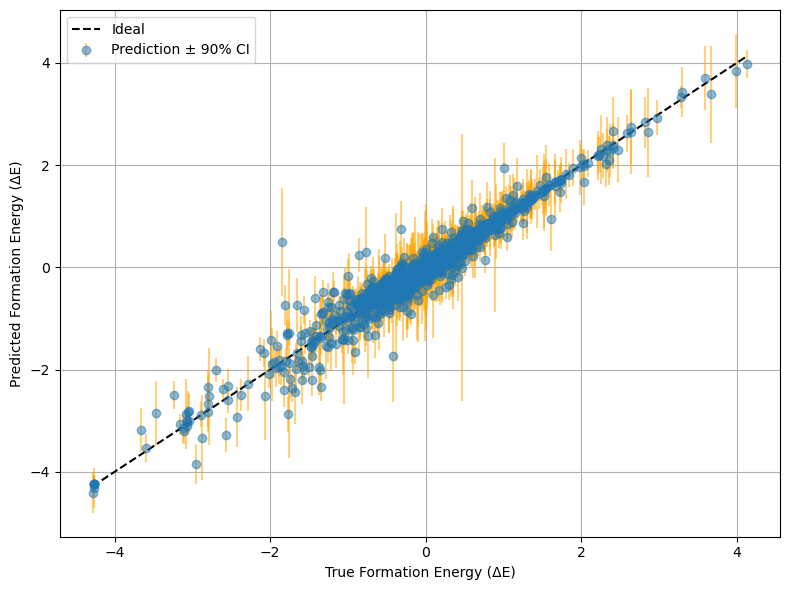

In [9]:
# 可视化：真实值vs预测值+区间
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred, yerr=z_score * y_std, fmt='o', ecolor='orange', alpha=0.5, label='Prediction ± 90% CI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
# plt.title("90% Confidence Interval of Predictions vs Ground Truth")
plt.xlabel("True Formation Energy (ΔE)")
plt.ylabel("Predicted Formation Energy (ΔE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

模型结果保存

In [10]:
df_gpr = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'std': y_std
})

df_gpr['residual'] = df_gpr['true'] - df_gpr['pred']

df_gpr.to_csv('data/gpr_results.csv', index=False)